# Behind the pipeline


The pipeline groups together three steps: preprocessing, passing the inputs through the model, and postprocessing:

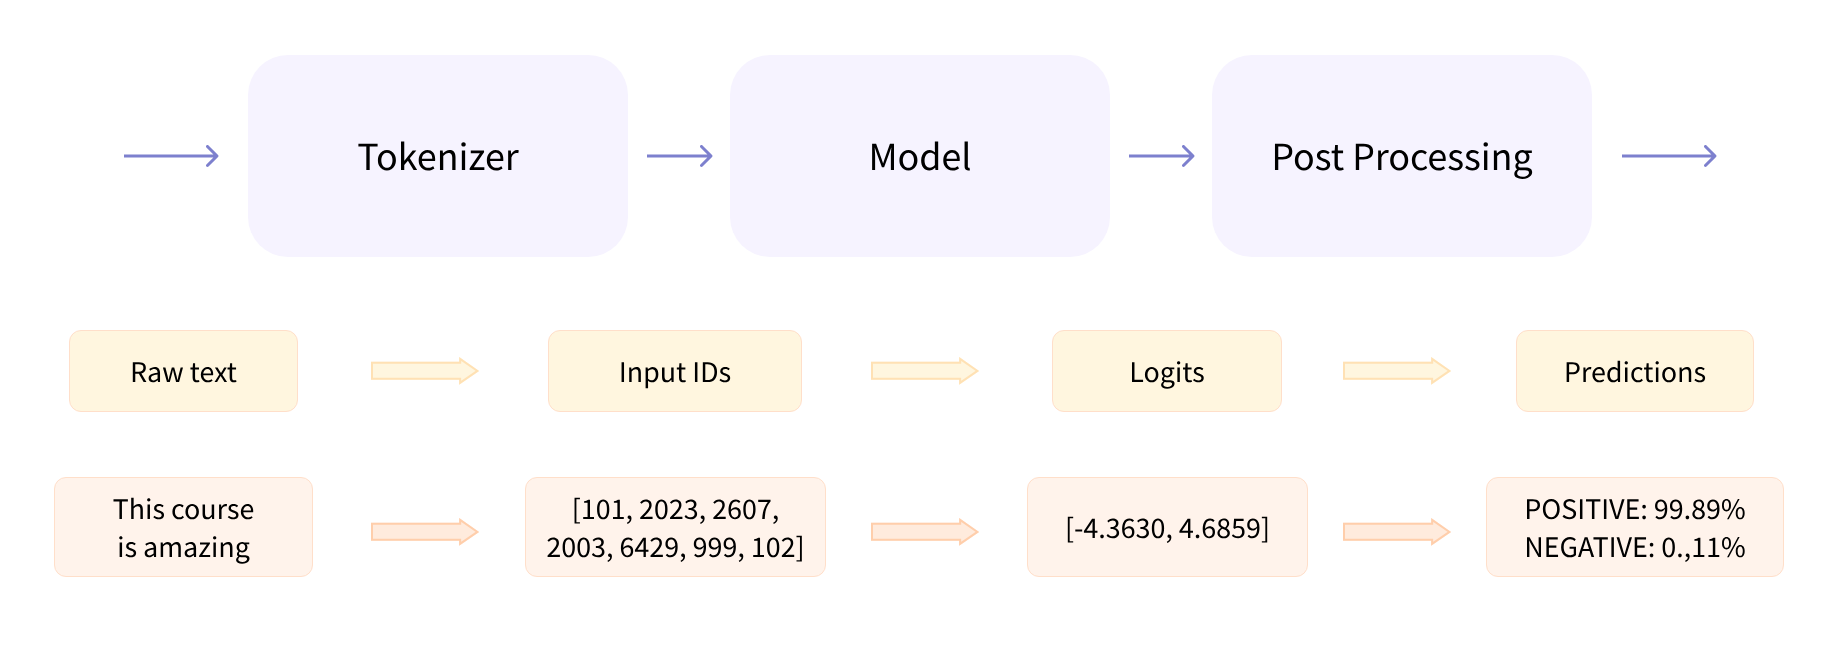

## 1. Preprocessing with a tokenizer


Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a `tokenizer`, which will be responsible for:

1. Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens

2. Mapping each token to an integer

3. Adding additional inputs that may be useful to the model

All this preprocessing needs to be done in exactly the same way as when the model was pretrained, so we first need to download that information from the Model Hub. To do this, we use the `AutoTokenizer` class and its `from_pretrained()` method. Using the checkpoint name of our model, it will automatically fetch the data associated with the model’s tokenizer and cache it (so it’s only downloaded the first time you run the code below).



Since the default checkpoint of the `sentiment-analysis` pipeline is `distilbert-base-uncased-finetuned-sst-2-english` (you can see its model card here), we run the following:



In [1]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

c:\Users\DELL\.conda\envs\torch_env\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model! The only thing left to do is to convert the list of input IDs to tensors.



To specify the type of tensors we want to get back (PyTorch or plain NumPy), we use the `return_tensors` argument:



In [2]:
raw_inputs = [
    "Even though I've been waiting for this for 2 years, i feel disappointed when i see it.",
    "It's not bad though."
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors='pt')
print(inputs)

{'input_ids': tensor([[ 101, 2130, 2295, 1045, 1005, 2310, 2042, 3403, 2005, 2023, 2005, 1016,
         2086, 1010, 1045, 2514, 9364, 2043, 1045, 2156, 2009, 1012,  102],
        [ 101, 2009, 1005, 1055, 2025, 2919, 2295, 1012,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


The output itself is a dictionary containing two keys, `input_ids` and `attention_mask`. `input_ids` contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence. We’ll explain what the `attention_mask` is later in this chapter.

## 2. Going through the model


We can download our pretrained model the same way we did with our tokenizer. 🤗 Transformers provides an `AutoModel` class which also has a `from_pretrained()` method:



In [3]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased-finetuned-sst-2-english
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


This architecture contains only the base Transformer module: given some inputs, it outputs what we’ll call hidden states, also known as features. For each model input, we’ll retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model.



While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the head. The different tasks could have been performed with the same architecture, but each of these tasks will have a different head associated with it.



### 2.1. A high-dimensional vector

The vector output by the Transformer module is usually large. It generally has three dimensions:



1. **Batch size**: The number of sequences processed at a time (2 in our example).

2. **Sequence length**: The length of the numerical representation of the sequence (16 in our example).

3. **Hidden size**: The vector dimension of each model input.

In [4]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)
print(outputs[0].shape)

torch.Size([2, 23, 768])
torch.Size([2, 23, 768])


Note that the outputs of 🤗 Transformers models behave like namedtuples or dictionaries. You can access the elements by attributes (like we did) or by key (`outputs["last_hidden_state"]`), or even by index if you know exactly where the thing you are looking for is (`outputs[0]`).

### 2.2. Model heads: Making sense out of numbers


The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:



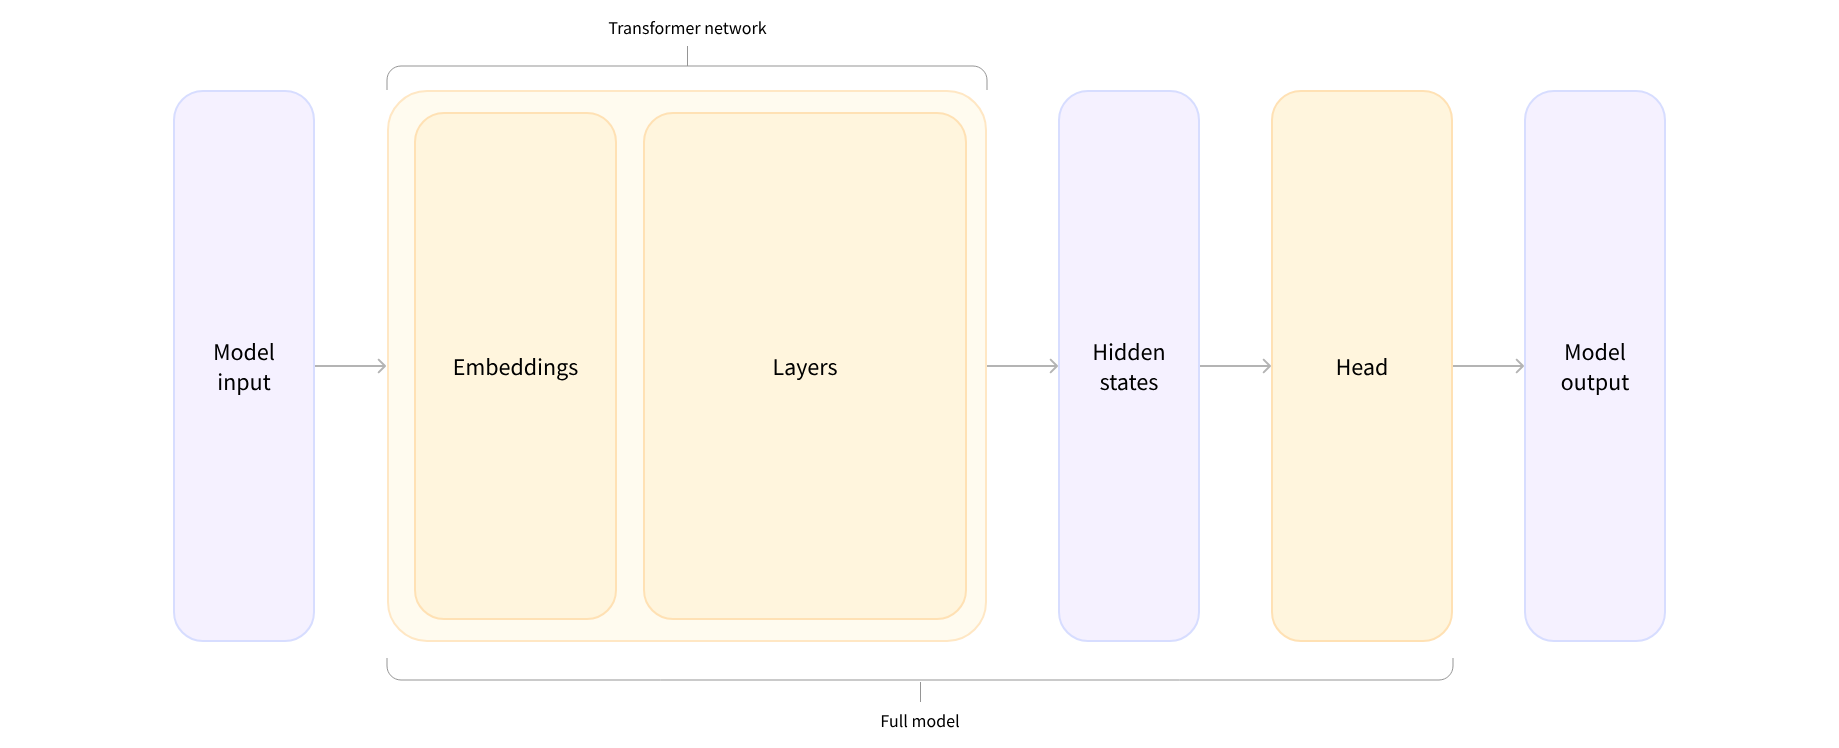

The output of the Transformer model is sent directly to the model head to be processed.



In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.



For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the `AutoModel` class, but `AutoModelForSequenceClassification`:



In [6]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

torch.Size([2, 2])


Now if we look at the shape of our outputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors we saw before, and outputs vectors containing two values (one per label)

Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.



## 3. Postprocessing the output


The values we get as output from our model don’t necessarily make sense by themselves. Let’s take a look:



In [7]:
print(outputs.logits)

tensor([[ 3.7196, -3.0640],
        [-3.7243,  3.9356]], grad_fn=<AddmmBackward0>)


Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [8]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[9.9887e-01, 1.1309e-03],
        [4.7113e-04, 9.9953e-01]], grad_fn=<SoftmaxBackward0>)


To get the labels corresponding to each position, we can inspect the `id2label` attribute of the model config (more on this in the next section):

In [9]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

In [10]:
model.config.label2id

{'NEGATIVE': 0, 'POSITIVE': 1}